In [ ]:
"""
This notebook walks through taking the training, validation, and testing data from the
EDA_preprocessing notebook, and finding the best LightGBMClassifier model with this data. I also
perform some data analysis with a suggestion for cost savings at the end based on the results of
my champion model.
"""

import mlflow
import mlflow.sklearn
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import shap
import warnings

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from lightgbm import early_stopping, log_evaluation, LGBMClassifier
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from pathlib import Path
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    roc_auc_score,
    roc_curve,
    auc,
    f1_score,
    recall_score,
    precision_score,
    confusion_matrix,
    classification_report,
)
from sklearn.model_selection import StratifiedKFold, cross_val_predict


def log_standard_metrics(
    y_true: np.ndarray, y_pred: np.ndarray, y_proba: np.ndarray, prefix: str
):
    """
    Function to emcompass logging metrics with MLFlow.

    Parameters
    ----------
    y_true: np.ndarray
        A numpy array of the true class labels
    y_pred: np.ndarray
        A numpy array of the predicted class labels
    y_proba: np.ndarray
        A numpy array of the predicted probabilities
    prefix: str
        A string referring to the type of dataset (e.g. train, valid, test)
    """
    mlflow.log_metric(f"log_loss_{prefix}", log_loss(y_true, y_proba))
    mlflow.log_metric(f"accuracy_{prefix}", accuracy_score(y_true, y_pred))
    try:
        mlflow.log_metric(f"auc_{prefix}", roc_auc_score(y_true, y_proba[:, 1]))
    except:
        pass
    mlflow.log_metric(f"f1_{prefix}", f1_score(y_true, y_pred))
    mlflow.log_metric(f"recall_{prefix}", recall_score(y_true, y_pred))
    mlflow.log_metric(f"precision_{prefix}", precision_score(y_true, y_pred))


def log_confusion_matrix(y_true: pd.Series, y_pred: np.ndarray, name: str):
    """
    Given the true and predicted class labels, log a confusion matrix of the results.

    Parameters
    ----------
    y_true: pd.Series
        A pandas series of the true class labels
    y_pred: np.ndarray
        A numpy array of the predicted class labels
    name: str
        A string to title each confusion matrix accordingly
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix: {name}")
    cm_path = f"cm_{name}.png"
    plt.tight_layout()
    plt.savefig(cm_path, dpi=150)
    plt.close()

    mlflow.log_artifact(cm_path)


def log_feature_importances(
    model: LGBMClassifier,
    train_data: pd.DataFrame,
    valid_data: pd.DataFrame,
    valid_target: pd.Series,
):
    """
    Given an LGBMClassifier object and the training data, calculate and log the split, gain, and
    permutation feature importances for the trained model.

    Parameters
    ----------
    model: LGBMClassifier
        The trained LGBMClassifier model
    train_data: pd.DataFrame
        The training data for the model. This is just used to extract the column (feature) names
    valid_data: pd.DataFrame
        The validation data
    valid_target: pd.Series
        The corresponding target column of the validation data
    """
    # Calculate split and gain importance
    importances_split = pd.Series(
        model.booster_.feature_importance(importance_type="split"),
        index=train_data.columns,
    )
    importances_gain = pd.Series(
        model.booster_.feature_importance(importance_type="gain"),
        index=train_data.columns,
    )

    # Permutation importance
    perm_result = permutation_importance(
        model,
        valid_data,
        valid_target,
        n_repeats=10,
        random_state=RNG_SEED,
        scoring="neg_log_loss",
    )
    importances_perm = pd.Series(perm_result.importances_mean, index=valid_data.columns)

    # Save and log each
    importances_split.sort_values(ascending=False).to_csv(
        "feature_importance_split.csv", index=False
    )
    importances_gain.sort_values(ascending=False).to_csv(
        "feature_importance_gain.csv", index=False
    )
    importances_perm.sort_values(ascending=False).to_csv(
        "feature_importance_perm.csv", index=False
    )

    mlflow.log_artifact("feature_importance_split.csv")
    mlflow.log_artifact("feature_importance_gain.csv")
    mlflow.log_artifact("feature_importance_perm.csv")

    # Summary table
    df_all_importances = pd.DataFrame(
        {
            "split_importance": importances_split,
            "gain_importance": importances_gain,
            "perm_importance": importances_perm,
        }
    )
    df_all_importances.sort_values(by="gain_importance", ascending=False).to_csv(
        "feature_importance_all.csv", index=False
    )
    mlflow.log_artifact("feature_importance_all.csv")


def log_model(model: LGBMClassifier, train_data: pd.DataFrame, index: int):
    """
    Given a LGBMClassifier model and the training data, infer the model signature and log the model.

    Parameters
    ----------
    model: LGBMClassifier
        The trained LGBMClassifier model
    train_data: pd.DataFrame
        The training data for the model
    index: int
        An integer for the best iteration of the model
    """
    # Infer signature using predict_proba on train, and log model with this signature
    y_train_proba = model.predict_proba(train_data, num_iteration=index)
    signature = infer_signature(train_data, y_train_proba)
    mlflow.lightgbm.log_model(model, "model", signature=signature)


def log_shap_plot(model: LGBMClassifier, valid_data: pd.DataFrame):
    """
    Given the LGBMClassifier model, calculate SHAP values and log a beeswarm plot of the
    features.

    Parameters
    ----------
    model: LGBMClassifier
        The trained LGBMClassifier model
    valid_data: pd.DataFrame
        The training data for the model.
    """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(valid_data)

    plt.figure()
    shap.summary_plot(shap_values, valid_data, show=False)
    plt.tight_layout()
    shap_path = "shap_summary.png"
    plt.savefig(shap_path, dpi=150)
    plt.close()
    mlflow.log_artifact(shap_path)


def objective(params: dict) -> float:
    """
    Objective function to optimize for MLFlow. This emcompasses what happens in a single MLFlow run.

    Parameters
    ----------
    params: dict
        A dictionary of hyperparameters for the LGBMClassifier model. This is defined via the search
        space via HyperOPT with the TPE algorithm

    Returns
    -------
    float
        The corresponding binary log-loss of the MLFlow run. The best run is determined via the
        lowest loss
    """
    # Convert certain parameters as integers
    params["num_leaves"] = int(params["num_leaves"])
    params["max_depth"] = int(params["max_depth"])
    params["n_estimators"] = int(params["n_estimators"])
    params["min_child_samples"] = int(params["min_child_samples"])

    with mlflow.start_run(nested=True):

        mlflow.log_params(params)
        model = LGBMClassifier(**params, random_state=RNG_SEED, n_jobs=-1)

        # Fit with early stopping to avoid model overfitting if loss does not decrease after
        # x early stopping rounds
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric="logloss",
            callbacks=[
                early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS, verbose=False),
                log_evaluation(0),
            ],
        )

        # Note the best iteration with the lowest logloss for this MLFlow run
        best_iter = model.best_iteration_ or params["n_estimators"]

        # Evaluate on train/valid/test using best iteration
        for split_name, X, y in [
            ("train", X_train, y_train),
            ("valid", X_valid, y_valid),
            ("test", X_test, y_test),
        ]:
            y_proba = model.predict_proba(X, num_iteration=best_iter)
            y_pred = (
                np.argmax(y_proba, axis=1)
                if y_proba.shape[1] > 1
                else (y_proba > 0.5).astype(int)
            )

            # Log standard metrics
            log_standard_metrics(
                y_true=y, y_pred=y_pred, y_proba=y_proba, prefix=split_name
            )

            # Log macro-averaged metrics
            mlflow.log_metric(
                f"macro_precision_{split_name}",
                precision_score(y, y_pred, average="macro"),
            )
            mlflow.log_metric(
                f"macro_recall_{split_name}", recall_score(y, y_pred, average="macro")
            )
            mlflow.log_metric(
                f"macro_f1_{split_name}", f1_score(y, y_pred, average="macro")
            )

            # Log confusion matrix with the trained model for each dataset
            log_confusion_matrix(y_true=y, y_pred=y_pred, name=split_name)

        # Log index of best iteration
        mlflow.log_param("best_iteration", best_iter)

        # Log feature importances
        log_feature_importances(
            model=model, train_data=X_train, valid_data=X_valid, valid_target=y_valid
        )

        # Log shap plot
        log_shap_plot(model=model, valid_data=X_valid)

        # Log model
        log_model(model=model, train_data=X_train, index=best_iter)

        val_loss = log_loss(
            y_valid, model.predict_proba(X_valid, num_iteration=best_iter)
        )
        return {"loss": val_loss, "status": STATUS_OK}


# Setting some global variables
EARLY_STOPPING_ROUNDS = 50
SEARCH_SPACE = {
    "num_leaves": hp.quniform("num_leaves", 20, 150, 1),
    "max_depth": hp.quniform("max_depth", 3, 15, 1),
    "learning_rate": hp.loguniform("learning_rate", -4, -1),
    "n_estimators": hp.quniform("n_estimators", 100, 1000, 50),
    "min_child_samples": hp.quniform("min_child_samples", 10, 100, 5),
    "subsample": hp.uniform("subsample", 0.6, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),
    "reg_alpha": hp.uniform("reg_alpha", 0.0, 1.0),
    "reg_lambda": hp.uniform("reg_lambda", 0.0, 1.0),
    "verbosity": hp.choice("verbosity", [-1]),
    "class_weight": "balanced",
}
RNG_SEED = 42

# Setting up backend things for MLFlow code to run smoothly
client = MlflowClient()
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("WNV_modeling")

warnings.filterwarnings("ignore")

Here, I load in the data created from the previous task.

In [42]:
# Import data from previous task
train_data = pd.read_pickle("../data/train_selected.pkl")
valid_data = pd.read_pickle("../data/valid_selected.pkl")
test_data = pd.read_pickle("../data/test_selected.pkl")

# Setup train/valid/test data
X_train = train_data.drop(["WnvPresent"], axis=1)
y_train = train_data["WnvPresent"]
X_valid = valid_data.drop(["WnvPresent"], axis=1)
y_valid = valid_data["WnvPresent"]
X_test = test_data.drop(["WnvPresent"], axis=1)
y_test = test_data["WnvPresent"]

# Get feature names
features_names = X_train.columns

Now, I run the MLFlow experiment!

In [43]:
# NOTE: Run `mlflow ui` in command prompt to have results stored in local URL

# Run the MLFlow experiment
trials = Trials()
best_params = fmin(
    fn=objective, space=SEARCH_SPACE, algo=tpe.suggest, max_evals=50, trials=trials
)

🏃 View run lyrical-chimp-833 at: http://127.0.0.1:5000/#/experiments/607756212728046995/runs/fea1993851a74dc2a760587a32c716f5

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/607756212728046995

🏃 View run charming-hen-448 at: http://127.0.0.1:5000/#/experiments/607756212728046995/runs/5e552e002e1e4633a35e07a4d0fa0120

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/607756212728046995   

🏃 View run big-tern-776 at: http://127.0.0.1:5000/#/experiments/607756212728046995/runs/ec45cf41568c478da4289e63c2b1039a

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/607756212728046995   

🏃 View run welcoming-goat-462 at: http://127.0.0.1:5000/#/experiments/607756212728046995/runs/b418cd58d44f415e8941bfbbc3b17d35

🧪 View experiment at: http://127.0.0.1:5000/#/experiments/607756212728046995  

🏃 View run enchanting-panda-667 at: http://127.0.0.1:5000/#/experiments/607756212728046995/runs/93944f47416c4db5889c57e14ce3f754

🧪 View experiment at: http://127.0.0.1:5000/#/e

Here, I want to get the information from my best run in the MLFlow experiment.

In [44]:
experiment = client.get_experiment_by_name("WNV_modeling")
experiment_id = experiment.experiment_id

# Displaying the actual experiment ID so I can reference it in my local /mlartifacts directory
print(f"Experiment ID is :{experiment_id}")

# Search for all runs, order by lowest validation loss
runs = client.search_runs(
    experiment_ids=[experiment_id],
    filter_string="attributes.status = 'FINISHED'",
    order_by=["metrics.log_loss_valid ASC"],
    max_results=1,
)

# Display the run ID, parameters, metrics, and artifacts of the best run determined above
if runs:
    best_run = runs[0]
    print("Best Run ID:", best_run.info.run_id)
    print("\nParameters:")
    for k, v in best_run.data.params.items():
        print(f"  {k}: {v}")
    print("\nMetrics:")
    for k, v in best_run.data.metrics.items():
        print(f"  {k}: {v}")
    print("\nArtifacts:")
    artifacts = client.list_artifacts(best_run.info.run_id)
    for artifact in artifacts:
        print(f"  {artifact.path}")
else:
    print("No finished runs found in experiment.")

Experiment ID is :607756212728046995
Best Run ID: a104f38fe7f64ecba4a7195bfdc82427

Parameters:
  best_iteration: 110
  class_weight: balanced
  colsample_bytree: 0.7538153845392795
  learning_rate: 0.020962153839011517
  max_depth: 15
  min_child_samples: 10
  num_leaves: 80
  n_estimators: 650
  reg_alpha: 0.25937574959790305
  reg_lambda: 0.30732239821773966
  subsample: 0.6025999347354074
  verbosity: -1

Metrics:
  accuracy_test: 0.9138266796494645
  accuracy_train: 0.8421317244846657
  accuracy_valid: 0.8712374581939799
  auc_test: 0.6552152790589393
  auc_train: 0.9591654308782336
  auc_valid: 0.6762248647892306
  f1_test: 0.06349206349206349
  f1_train: 0.34854771784232363
  f1_valid: 0.125
  log_loss_test: 0.23208074894757189
  log_loss_train: 0.3049479085629518
  log_loss_valid: 0.34089974346191587
  macro_f1_test: 0.5091637403451641
  macro_f1_train: 0.6293653921019399
  macro_f1_valid: 0.5277527075812274
  macro_precision_test: 0.5094598429666067
  macro_precision_train: 0.

For simplicity, I go ahead and retrieve the artifacts, since they cannot be displayed directly.

In [45]:
# Referencing the /mlartifacts directory on my local machine
mlruns = rf"C:\Users\kevin\OneDrive\Documents\mlartifacts\{experiment_id}\{best_run.info.run_id}\artifacts"
mlruns

from pathlib import Path
import matplotlib.image as mpimg

artifact_dir = Path(mlruns)

In [55]:
# Display the feature importances table
csv_path = artifact_dir / "feature_importance_all.csv"
df = pd.read_csv(csv_path)
print(df)

                Unnamed: 0  split_importance  gain_importance  perm_importance
0   trap_percent_with_wnv2              2320     35526.800158        -0.010331
1                  Sunrise               707     24879.093455         0.009636
2    trap_percent_with_wnv              2830     21700.541524        -0.013794
3                 DewPoint               513      9271.763458         0.003491
4              day_of_year               287      8781.001044        -0.009327
5                     Cool               170      7727.572501        -0.001739
6                 AvgSpeed               515      3825.569222        -0.000929
7                  WetBulb               184      2461.049637        -0.002058
8              ResultSpeed               276      2400.416592        -0.001557
9                     Tmin               211      1130.861700        -0.000411
10                      BR                63      1059.630050         0.001144
11                    Tavg                55       9

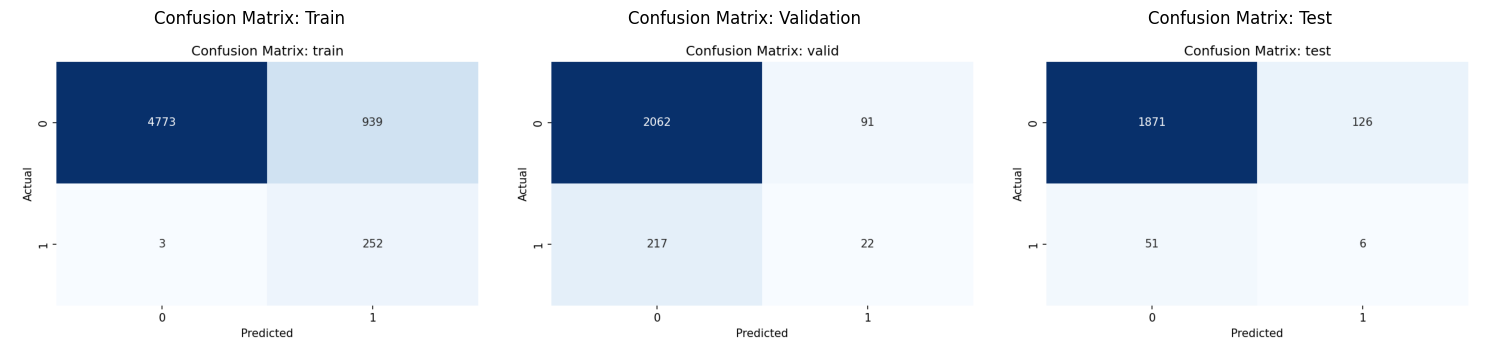

In [47]:
# Display the confusion matrices
artifact_dir = Path(mlruns)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

cm_files = ["cm_train.png", "cm_valid.png", "cm_test.png"]
titles = ["Train", "Validation", "Test"]

for ax, name, title in zip(axes, cm_files, titles):
    img_path = artifact_dir / name
    if img_path.exists():
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"Confusion Matrix: {title}")
    else:
        ax.set_visible(False)

plt.tight_layout()
plt.show()

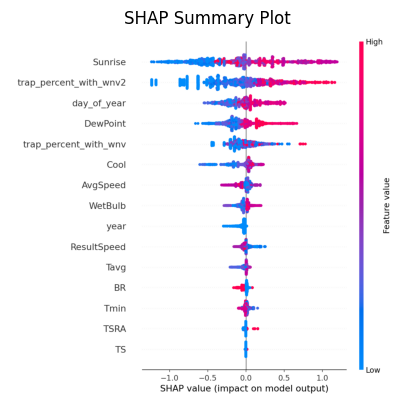

In [48]:
# Display the SHAP plot
img_path = artifact_dir / "shap_summary.png"
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis("off")
plt.title("SHAP Summary Plot")
plt.show()

This shows a few things. In particular, across the feature importances table and the SHAP plot, 
features like `Sunrise`, `trap_percent_with_wnv2`, and `day_of_year` are very important features,
with higher SHAP values and larger values for gain and split importance. However, I do see some 
somewhat significant permutation importance that's negative for `trap_percent_with_wnv` and 
`trap_percent_with_wnv2`, meaning that the model performance *increased* after shuffling values for
those features. Though, given this negative value was ~0.01, this is not that significant and was
likely due to random noise. Permutation importance overall was not the best indicator of feature 
importance here, but it's still good to have as a standard importance metric to log.

Regarding the actual model performance, recall for class 0 was very good (most of the actual 
observations where WNV was not detected, were predicted as not being there), but recall for class 1
is significantly lower (most of the observations where WNV was detected, was predicted as not being 
there). This is likely due to the class imbalance.

Nonetheless, I retrain my model with the optimal parameters after combining my training and 
validation dataset into a final training dataset. I measure the performance with ROC/AUC, which I
will use for the final set of analysis with this classical modeling approach.

In [ ]:
# Combine training and validation data
X_train_full = pd.concat([X_train, X_valid], axis=0)
y_train_full = pd.concat([y_train, y_valid], axis=0)

# Prepare parameter grid for LightGBM using best_params
param_grid = best_params.copy()
# Explicitly cast integer parameters to int
for key in ["num_leaves", "max_depth", "n_estimators", "min_child_samples"]:
    if key in param_grid:
        param_grid[key] = int(param_grid[key])
# Cast the rest to float (if not already int)
for key in param_grid:
    if key not in [
        "num_leaves",
        "max_depth",
        "n_estimators",
        "min_child_samples",
        "verbosity",
    ]:
        param_grid[key] = float(param_grid[key])

# Final adjustments to the param_grid
param_grid.pop("verbosity", None)
param_grid["random_state"] = RNG_SEED
param_grid["n_jobs"] = -1
param_grid.pop("best_iteration", None)

CV AUC: 0.8283203914230782


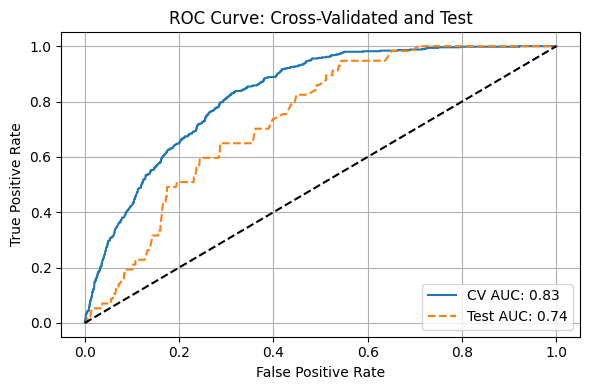

In [ ]:
# Define model
model = LGBMClassifier(**param_grid)

# Define stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG_SEED)

# Cross-validated AUC
y_score = cross_val_predict(
    model, X_train_full, y_train_full, cv=cv, method="predict_proba"
)[:, 1]
fpr, tpr, _ = roc_curve(y_train_full, y_score)
print("CV AUC:", auc(fpr, tpr))

# Train on full training data
model.fit(X_train_full, y_train_full)

# Evaluate on test set
y_test_proba = model.predict_proba(X_test)[:, 1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
test_auc = auc(fpr_test, tpr_test)

# Plot both curves
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label="CV AUC: {:.2f}".format(auc(fpr, tpr)))
plt.plot(fpr_test, tpr_test, label="Test AUC: {:.2f}".format(test_auc), linestyle="--")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Cross-Validated and Test")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

Overall, accuracy isn't terrible, but not great. And given the results from the MLFlow pipline, it
is clear that predicting the positive class of `WnvPresent` is unfeasible without more data for 
WNV being present (though downsampling could be used*, but I chose to avoid it since it might remove 
temporal patterns from the training data). Thus, the viewpoint with classical modeling is instead to 
show where testing should **NOT** be done! 

I do this by defining some TPR thresholds, since the thresholds (referring to the thresholds used
for assigning the probabilities to the class labels) for the ROC must be very low (<0.2, vs. the
default of 0.5) to successfully pick up traps with WNV. I'll also re-calculate the ROC/AUC with 
every data observation since the focus is no longer on getting the most accurate model.

*One could certainly use downsampling if model accuracy was a concern, but given this is a personal
project, I won't put too much emphasis on this, since the model would not be pushed to a formal
production pipeline anyways!

In [57]:
X = pd.concat([X_train_full, X_test], axis=0)
y = pd.concat([y_train_full, y_test], axis=0)

model = LGBMClassifier(**param_grid)

# Define stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG_SEED)

# Cross-validated AUC
y_score = cross_val_predict(model, X, y, cv=cv, method="predict_proba")[:, 1]
fpr, tpr, _ = roc_curve(y, y_score)
print("CV AUC:", auc(fpr, tpr))

# thresholds for TPR of 80%, 85%, 90%, 95%, and 100%, based on the test
thresh = [
    [th for t, f, th in zip(fpr_test, tpr_test, _) if t >= i][0]
    for i in [0.8, 0.85, 0.9, 0.95, 1]
]
# Print classification reports for each threshold corresponding to the TPRs above.
for i in thresh:
    predictions = [1 if p >= i else 0 for p in y_score]
    print(f"threshold:{i}")
    print(classification_report(y, predictions))

CV AUC: 0.8347821534269102
threshold:0.13444101991358345
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      9862
           1       0.21      0.48      0.29       551

    accuracy                           0.88     10413
   macro avg       0.59      0.69      0.61     10413
weighted avg       0.93      0.88      0.90     10413

threshold:0.12948668109266803
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      9862
           1       0.21      0.50      0.29       551

    accuracy                           0.87     10413
   macro avg       0.59      0.70      0.61     10413
weighted avg       0.93      0.87      0.90     10413

threshold:0.11910638572797197
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      9862
           1       0.20      0.50      0.29       551

    accuracy                           0.87     10413
   macro av

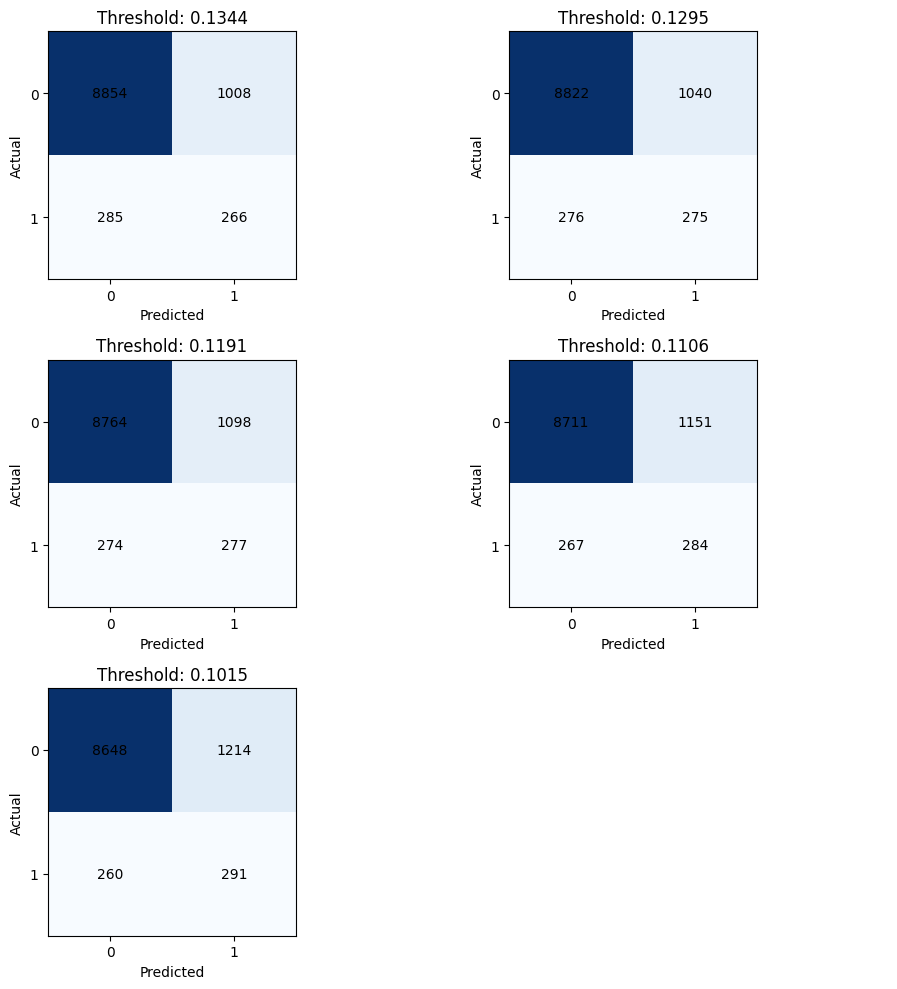

In [80]:
# Displaying a subplot of confusion matrices corresponding to the TPRs above

fig, axes = plt.subplots(3, 2, figsize=(10, 10))  # axes.shape == (3, 2)

for idx, threshold in enumerate(thresh[:5]):
    row, col = divmod(idx, 2)  # map 0-4 → (row, col)
    ax = axes[row, col]

    preds = (y_score >= threshold).astype(int)
    cm = confusion_matrix(y, preds)

    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(f"Threshold: {threshold:.4f}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])

# blank bottom-right panel (row 2, col 1)
axes[2, 1].axis("off")

plt.tight_layout()
plt.show()

As one can see, as the probability threshold for predicting class 1 (WNV being present) decreases, 
the number of correct predictions for these rare cases where WNV is present, goes up! With this 
information, I can propose a cost saving measure. Each set of tests for detecting whether mosquitoes
have WNV costs ~$100, so I calculate the average yearly savings associated with each threshold based
on this number.

In [81]:
savings = []
# Print average yearly savings associated with each threshold
for i in thresh:
    p = [1 if score >= i else 0 for score in y_score]
    value = (confusion_matrix(y, p)[0, 0] + confusion_matrix(y, p)[1, 0]) * 100 / 4
    savings.append(value)
print(savings)

[np.float64(228475.0), np.float64(227450.0), np.float64(225950.0), np.float64(224450.0), np.float64(222700.0)]


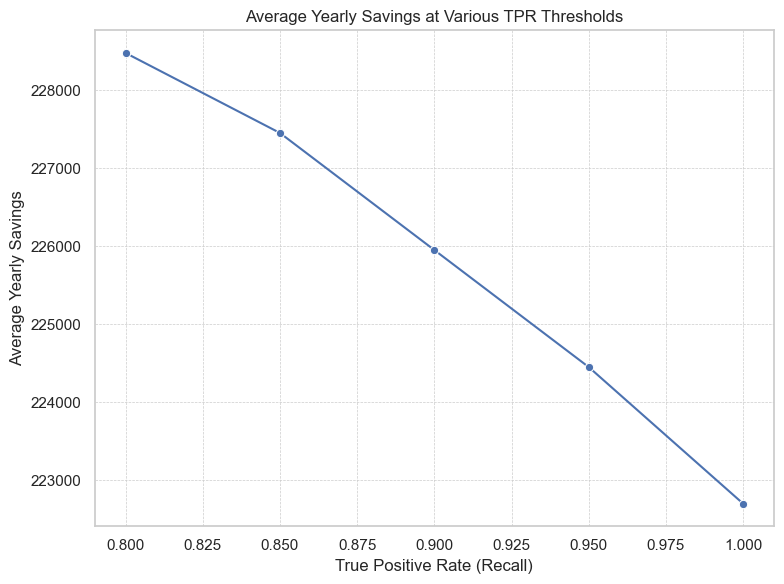

In [83]:
# Graphing savings at each TPR rate
recall = [0.8, 0.85, 0.9, 0.95, 1.0]
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.lineplot(x=recall, y=savings, marker="o")
plt.title("Average Yearly Savings at Various TPR Thresholds")
plt.xlabel("True Positive Rate (Recall)")
plt.ylabel("Average Yearly Savings")
plt.grid(visible=True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

Any one of these TPR thresholds could be chosen. Ideally, the main "kink" in the graph (where 
average yearly savings decreases at a noticably faster rate) is at a TPR of 0.85, so it is 
recommended to pick this. The corresponding prediction threshold is 0.12948668109266803, meaning 
that if a mosquito has an estimated probability greater than ~13% of being positive for WNV, it 
would be worthwhile to send it in for proper testing, which would lead to an approximate savings of 
$227450 USD!

From here, a calculated # of traps to not be tested can be shown.

In [85]:
# Calculate the number of traps to not be tested
traps_not_tested = [float(s) / 100 for s in savings]

# Create a DataFrame with recall, savings, and traps_not_tested
df_savings = pd.DataFrame({
    "Recall": recall,
    "Average Yearly Savings": savings,
    "Traps Not Tested": traps_not_tested
})

print(df_savings)

   Recall  Average Yearly Savings  Traps Not Tested
0    0.80                228475.0           2284.75
1    0.85                227450.0           2274.50
2    0.90                225950.0           2259.50
3    0.95                224450.0           2244.50
4    1.00                222700.0           2227.00


Of course, given the time range of this data, it is very likely that different patterns, and thus 
different conclusions would be seen. But, it would follow the same procedure as what was done here 
with the data I was able to get. Future work will hopefully expand the date range.